# Part 2 - Categorically Speaking

**Notice: This notebook is a modification of [cats.ipynb and targetencode.ipynb](https://mlbook.explained.ai/notebooks/index.html) by Terence Parr and Jeremy Howard, which were used by permission of the author.**

Please use this notebook to follow along with the lectures this week. Feel free to modify the code in any way. 

There may be minor differences between the notebook seen in the lecture videos and this one. 

### Reestablish Baseline

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
from rfpimp import *

C:\Users\MCASSAR\Anaconda3\envs\DAB300-F20\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def evaluate(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)
    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))
    print(f"OOB R^2 is {oob:.5f} using {n:,d} tree nodes with {h} median tree depth")
    return rf, oob

In [3]:
def showimp(rf, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    I = importances(rf, X, y, features=features)
    plot_importances(I, color='#4575b4')

In [4]:
rent = pd.read_csv('rent.csv')

rent_clean = rent[(rent['price'] > 1000) & (rent['price'] < 10000)]
rent_clean = rent_clean[(rent_clean['longitude'] !=0) | (rent_clean['latitude']!=0)]
rent_clean = rent_clean[(rent_clean['latitude']>40.55) &
                        (rent_clean['latitude']<40.94) &
                        (rent_clean['longitude']>-74.1) &
                        (rent_clean['longitude']<-73.67)]

In [5]:
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']

X = rent_clean[numfeatures]
y = rent_clean['price']

rf, oob = evaluate(X, y)

OOB R^2 is 0.86758 using 2,431,678 tree nodes with 35.0 median tree depth


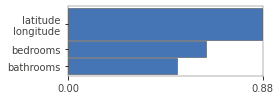

In [6]:
showimp(rf, X, y)

### Categorical Variables

Recall that categorical variables tend to come in two kinds:
- Ordinal
    - where there is some natural ordering to the categories
- Nominal
    - where there is no natural ordering to the categories

### What Have We Ignored So Far?

Our baseline model used the numeric features `bathrooms`, `bedrooms`, `longtitude`, and `latitutde`, but we know that our data has other features. We would now like to see if these features contain any information that our model can use; that is, to help the model better understand the relationship between the features and the target so as to improve its ability to make accurate predictions. 

Let's first look at the remaining features. 

In [7]:
nonnum = [col for col in rent_clean.columns.tolist() if col not in numfeatures + ['price']]
nonnum

['building_id',
 'created',
 'description',
 'display_address',
 'features',
 'listing_id',
 'manager_id',
 'photos',
 'street_address',
 'interest_level']

In [8]:
rent_nonnum = rent_clean[nonnum]
rent_nonnum.head().T

,0,1,2,3,4
building_id,8579a0b0d54db803821a35a4a615e97a,b8e75fc949a6cd8225b455648a951712,cd759a988b8f23924b5a2058d5ab2b49,53a5b119ba8f7b61d4e010512e0dfc85,bfb9405149bfff42a92980b594c28234
created,2016-06-16 05:55:27,2016-06-01 05:44:33,2016-06-14 15:19:59,2016-06-24 07:54:24,2016-06-28 03:50:23
description,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Over-sized Studio w abundant closets. Availabl...
display_address,145 Borinquen Place,East 44th,East 56th Street,Metropolitan Avenue,East 34th Street
features,"['Dining Room', 'Pre-War', 'Laundry in Buildin...","['Doorman', 'Elevator', 'Laundry in Building',...","['Doorman', 'Elevator', 'Laundry in Building',...",[],"['Doorman', 'Elevator', 'Fitness Center', 'Lau..."
listing_id,7170325,7092344,7158677,7211212,7225292
manager_id,a10db4590843d78c784171a107bdacb4,955db33477af4f40004820b4aed804a0,c8b10a317b766204f08e613cef4ce7a0,5ba989232d0489da1b5f2c45f6688adc,2c3b41f588fbb5234d8a1e885a436cfa
photos,['https://photos.renthop.com/2/7170325_3bb5ac8...,['https://photos.renthop.com/2/7092344_7663c19...,['https://photos.renthop.com/2/7158677_c897a13...,['https://photos.renthop.com/2/7211212_1ed4542...,['https://photos.renthop.com/2/7225292_901f198...
street_address,145 Borinquen Place,230 East 44th,405 East 56th Street,792 Metropolitan Avenue,340 East 34th Street
interest_level,medium,low,medium,medium,low


How many rows and columns do we have?

In [9]:
rent_nonnum.shape

(48300, 10)

For each non-numeric column, let's find out how many unique values (that is, potential *categories*) there are:

In [10]:
rent_nonnum.nunique(dropna=False)

building_id         7417
created            47643
description        37491
display_address     8692
features            9924
listing_id         48300
manager_id          3409
photos             44703
street_address     15094
interest_level         3
dtype: int64

The first few things to notice are: 
- `interest_level` has only 3 categories
- all the other features potentially have 1000's of categories
- `listing_id` is a unique number per apartment so contains no information 
- `created` is a date which has almost as many values as apartments 

So, we'll ignore `created` and `listing_id` and we'll start with the simplest feature, `interest_level`. 

### Objective

Let's take a moment to remember what we are doing. In order to train a model we need numeric data. Our data however, has many features that may contain information about our target `price` but are not numeric. So, our objective now is to see if we can convert these features into some sort of sensible numeric representation that may improve the performance of our baseline model. 

### Before We Begin

Before we start tackling the categorical features in our data, we will need to install another package, called [category_encoders](https://contrib.scikit-learn.org/category_encoders/index.html). Much of this can be done in *sklearn*, but that is not always straightforward, or with straight python. To streamline our approach, we will use this new package so that we have a single interface to deal with. This package also integrates well with *sklearn*, *Pandas*, and *NumPy*. (Note: you will see some *FutureWarning* messages when using this package but these can be ignored just like we did for `rfpimp`.)

In [ ]:
!pip install category_encoders

### An Ordinal Variable: `interest_level`

This feature is an example of an *ordinal* categorical variable, which means there is a natural ordering. To see this, let's look at the unique values contained in this feature. 

In [11]:
rent_clean['interest_level'].unique()

array(['medium', 'low', 'high'], dtype=object)

We can now see that the obvious ordering is 

$$
\rm{low} \rightarrow \rm{medium} \rightarrow \rm{high}
$$

Now let's encode this feature using integers, making sure we maintain this ordering.  

We will first add the `interest_level` feature to our numeric features.

In [12]:
X = rent_clean[numfeatures + ['interest_level']]
y = rent_clean['price']
X.head()

,bathrooms,bedrooms,longitude,latitude,interest_level
0,1.0,1,-73.9539,40.7108,medium
1,1.0,2,-73.9722,40.7513,low
2,1.0,2,-73.9625,40.7575,medium
3,1.5,3,-73.9425,40.7145,medium
4,1.0,0,-73.9743,40.7439,low


And then encode this feature numerically.

In [13]:
import category_encoders as ce

encoder = ce.OrdinalEncoder(mapping=[{'col': 'interest_level', 'mapping': {'low': 1, 'medium': 2, 'high':3}}])

encoder.fit(X)
X = encoder.transform(X)
X.head()

,bathrooms,bedrooms,longitude,latitude,interest_level
0,1.0,1,-73.9539,40.7108,2
1,1.0,2,-73.9722,40.7513,1
2,1.0,2,-73.9625,40.7575,2
3,1.5,3,-73.9425,40.7145,2
4,1.0,0,-73.9743,40.7439,1


This approach called *ordinal encoding*. Note that the scale doesn't matter for random forests (although it may for another model), so it wouldn't matter if we used 1, 2, 3 or 10, 20, 30 to encode this variable, as long as we maintained the original ordering. *Label encoding* is similar, but just assigns an integer to each unique category value (assuming no order) and, as the name suggests, is often used to numerically encode target classes. 

Now that the feature is numeric, we can include it in our baseline model and then evaluate how it performs to see if including `interest_level` improves performance at all.

In [14]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.87085 using 3,024,152 tree nodes with 35.0 median tree depth


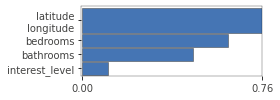

In [15]:
showimp(rf, X, y)

We see that including this feature gives us a slight increase in performance since our OOB $R^2$ is now 0.870 (up from 0.867). From the number of nodes in the forest we see that the model has to work a little harder when we include this feature. And we can also see that predictions will be a bit slower as the median depth of trees in the forest has increased from 35 to 36. 

But, the closer we get to $R^2 = 1$ the harder it is to get an improvement so we will keep this feature in.

### A Nominal Variable: `manager_id`

This type of categorical variable is more difficult to encode than an ordinal variable as there is often no meaningful way to encode as a number, especially when there are many category values. 

To get started, let's take a look at some typical values for this variable. 

In [16]:
rent_clean['manager_id'].unique()

array(['a10db4590843d78c784171a107bdacb4',
       '955db33477af4f40004820b4aed804a0',
       'c8b10a317b766204f08e613cef4ce7a0', ...,
       'bf077b3e472557cb660271eafe1629aa',
       '78a2411ba7621e3a54d8f325e44b92f4',
       'cda0d536fb182dfed7cc48f0884d3203'], dtype=object)

And determine how many unique values there are; that is, how many category values.

In [17]:
len(rent_clean['manager_id'].unique())

3409

This is an example of a *high-cardinality* categorical variable as it has many category values. For instance, compare this number to the number of category values we had to deal with for `interest_level`. 

The first thing we are going to try is to ignore that this is a *nominal* variable and treat it as if it were a *ordinal* one.

In [18]:
X = rent_clean[numfeatures + ['manager_id']]
y = rent_clean['price']
X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,a10db4590843d78c784171a107bdacb4
1,1.0,2,-73.9722,40.7513,955db33477af4f40004820b4aed804a0
2,1.0,2,-73.9625,40.7575,c8b10a317b766204f08e613cef4ce7a0
3,1.5,3,-73.9425,40.7145,5ba989232d0489da1b5f2c45f6688adc
4,1.0,0,-73.9743,40.7439,2c3b41f588fbb5234d8a1e885a436cfa


In [19]:
encoder = ce.OrdinalEncoder(cols=['manager_id'])

encoder.fit(X)
X = encoder.transform(X)
X.head()

C:\Users\MCASSAR\Anaconda3\envs\DAB300-F20\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,1
1,1.0,2,-73.9722,40.7513,2
2,1.0,2,-73.9625,40.7575,3
3,1.5,3,-73.9425,40.7145,4
4,1.0,0,-73.9743,40.7439,5


In [20]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86136 using 4,599,870 tree nodes with 40.0 median tree depth


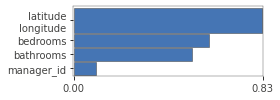

In [21]:
showimp(rf, X, y)

This doesn't improve our baseline $R^2$ performance and also adds many more nodes to the forest and about 5 levels to the median depth. So, this attempt doesn't work. 

We will now try a different method to encode this variable to see if that makes a difference: *frequency encoding*. In this approach we count up how many samples belong to each category and then replace each unique string value with the corresponding count. Let's see how this works. 

In [22]:
X = rent_clean[numfeatures + ['manager_id']]
y = rent_clean['price']
X.head()

,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,a10db4590843d78c784171a107bdacb4
1,1.0,2,-73.9722,40.7513,955db33477af4f40004820b4aed804a0
2,1.0,2,-73.9625,40.7575,c8b10a317b766204f08e613cef4ce7a0
3,1.5,3,-73.9425,40.7145,5ba989232d0489da1b5f2c45f6688adc
4,1.0,0,-73.9743,40.7439,2c3b41f588fbb5234d8a1e885a436cfa


In [23]:
encoder = ce.CountEncoder(cols=['manager_id'])

encoder.fit(X)
X = encoder.transform(X)
X.head()

C:\Users\MCASSAR\Anaconda3\envs\DAB300-F20\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,bathrooms,bedrooms,longitude,latitude,manager_id
0,1.0,1,-73.9539,40.7108,112
1,1.0,2,-73.9722,40.7513,26
2,1.0,2,-73.9625,40.7575,93
3,1.5,3,-73.9425,40.7145,90
4,1.0,0,-73.9743,40.7439,54


In [24]:
rf, oob = evaluate(X, y)

OOB R^2 is 0.86319 using 4,535,710 tree nodes with 40.0 median tree depth


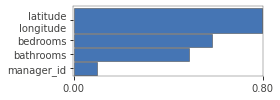

In [25]:
showimp(rf, X, y)

Again, we see that including this feature with this encoding doesn't improve our overall results over our baseline. 

High-cardinality variables tend to require more advanced encodings, like *embeddings* and *target encoding*. We will revisit this feature later, when we talk about target encoding. 

#### An Aside: One-Hot Encoding

Another common technique for encoding nominal variables is called *one-hot encoding*. We have already seen this approach in Lab 1, and although this approach is not useful for high-cardinality variables, it is a good time to review how it works. To show how it works we will use a toy dataframe. 

In [81]:
df = pd.DataFrame({'manager_id':['mgr 1', 'mgr 1', 'mgr 3', 'mgr 1', 'mgr 2', 'mgr 2'], 
                   'bedrooms':[1, 2, 1, 1, 3, 2], 
                   'price':[3590, 2780, 6450, 4100, 3900, 4200]})
df

,manager_id,bedrooms,price
0,mgr 1,1,3590
1,mgr 1,2,2780
2,mgr 3,1,6450
3,mgr 1,1,4100
4,mgr 2,3,3900
5,mgr 2,2,4200


And now we perform one-hot encoding on our pretend `manager_id` column.

In [82]:
encoder = ce.OneHotEncoder(cols=['manager_id'])

encoder.fit(df)
df = encoder.transform(df)
df

C:\Users\MCASSAR\Anaconda3\envs\DAB300-F20\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,manager_id_1,manager_id_2,manager_id_3,bedrooms,price
0,1,0,0,1,3590
1,1,0,0,2,2780
2,0,1,0,1,6450
3,1,0,0,1,4100
4,0,0,1,3,3900
5,0,0,1,2,4200


First note that we had 3 unique `manager_id` values in our toy dataset. When we do one-hot encoding on this data we will create 3 columns from the original `manager_id` column, one for each unique value. Then, we put a 1 (where one-hot comes from) in the column corresponding to the correct manager id for that sample (row) and 0's in the other two columns. If the number of unique values for the feature were 5 we would create 5 new columns instead of 3, as we did here, so this approach can be taken for any number of unique category values. 

However, note that if we had done this for the `manager_id` in our rent dataset, we would introduce 3409 new columns to our dataframe, which is impractical; that's too much computational overhead for a single feature. And, `manager_id`is not the only high-cardinality variable in our dataset. If we were to one-hot encode `manager_id`, `display_address`, and `building_id` we would add $3409 + 8692 + 7417 = 19518$ new columns to our data (see `rent_nonnum.nunique(dropna=False)` code cell above to see where these numbers came from). 

### Exercise

Repeat the procedures we took for `manager_id` but now explore the effect of including `building_id` and `display_address`. 